#### Loads

In [1]:
import pandas as pd
from DeepRetail.forecasting.statistical import StatisticalForecaster
from DeepRetail.exploratory.eda import get_features
from matplotlib import pyplot as plt
from DeepRetail.evaluation.base import Evaluator
# Import metrics for evaluation
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape
from DeepRetail.exploratory.eda import get_features
from DeepRetail.transformations.formats import MinMaxScaler_custom
from DeepRetail.forecasting.ml import GlobalForecaster
import lightgbm as lgb
import numpy as np

from DeepRetail.reconciliation.temporal import THieF, TemporalReconciler
from DeepRetail.reconciliation.utils import get_factors
from DeepRetail.reconciliation.cross_sectional import CHieF, CrossSectionalReconciler
from DeepRetail.transformations.formats import hierarchical_to_transaction, extract_hierarchical_structure
from DeepRetail.reconciliation.cross_temporal import CrossTemporalReconciler, C_THieF

/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Define metrics
metrics = [rmsse, scaled_error, mape]

In [3]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/Aldi_month_data.csv', index_col=0)
df_products = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/Aldi_products.csv', index_col=0)
df.head()

,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,...,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30
Item,,,,,,,,,,,,,,,,,,,,,
1009,16395.0,19569.0,25575.0,21140.0,21123.0,28675.0,24139.0,20738.0,27679.0,19878.0,...,22472.0,26115.0,20550.0,25723.0,14761.0,16793.0,22978.0,18413.0,21382.0,5288.0
101,38342.0,41657.0,51902.0,41198.0,41972.0,51841.0,41922.0,34607.0,42193.0,32626.0,...,24415.0,29668.0,22243.0,32940.0,20489.0,23085.0,28351.0,22577.0,22533.0,6436.0
1011,33309.0,38981.0,48528.0,34528.0,34350.0,40675.0,31671.0,34532.0,47411.0,42246.0,...,34269.0,44411.0,32677.0,50810.0,33782.0,36424.0,46740.0,40435.0,38437.0,9279.0
1014,11715.0,13326.0,15772.0,12069.0,12593.0,15664.0,12218.0,19091.0,23168.0,18353.0,...,5651.0,6254.0,5264.0,8312.0,5521.0,5015.0,6558.0,5813.0,6813.0,1604.0
1015,25997.0,29224.0,32826.0,23769.0,26856.0,32024.0,18622.0,27831.0,51193.0,30594.0,...,12775.0,17014.0,20839.0,28530.0,16273.0,14364.0,21303.0,19601.0,18017.0,4463.0


In [4]:
# Add a unique numeric code for each product family
df_products['product_family_code'] = df_products['ProductFamily'].astype('category').cat.codes

# add the product_family_code to the df
df = df.reset_index()
df = pd.merge(df, df_products[['product_family_code', 'unique_id']], left_on = 'Item', right_on = 'unique_id')

# Add the new unique_id
df['unique_id'] = df['product_family_code'].astype(str) + '_' + df['Item'].astype(str)

# drop the product_family_code and the Item columns
df = df.drop(['product_family_code', 'Item'], axis=1)

# Set the unique_id as index
df = df.set_index('unique_id')

In [5]:
# convert columns to datetime
df.columns = pd.to_datetime(df.columns)

# Drop columns with only nans
df = df.dropna(axis = 0, how = 'all')
df = df.fillna(0)

# Drop rows with only zeros
df = df.loc[~(df==0).all(axis=1)]

# Drop the last month cuz its incomplete
df = df.drop(df.columns[-1], axis = 1)

In [6]:
# Count non zero observations per row on df
non_zero_obs = df.astype(bool).sum(axis=1)

# Total series with over 5 non zero observations
print(len(non_zero_obs))
len(non_zero_obs[non_zero_obs > 5])

387


387

##### Split Data for the two Experiments

In [7]:
# Filter df to only include series with over 5 non zero observations
sample_df = df.loc[non_zero_obs[non_zero_obs > 5].index]
sample_df.shape

(387, 39)

In [8]:
# old experiment is the same!

#### Basic EDA

In [9]:
features = get_features(sample_df, seasonal_period = 12, periods = 12)
# Use thecustom minmax scaler to normalize lumpiness into 0-1
features['lumpiness'] = MinMaxScaler_custom(features['lumpiness'], feature_range=(0, 1))
features['linearity'] = MinMaxScaler_custom(features['linearity'], feature_range=(0, 1))
features

,unique_id,lumpiness,entropy,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough,Residual_CoV
0,0_1110,0.029414,0.801031,1,12,0.159223,0.000075,0.536714,-0.723574,-0.316046,0.553194,0.804153,12,9,0.702091
1,0_1113,0.057132,0.750271,1,12,0.591349,0.000064,0.522819,-2.896718,0.433105,1.817579,0.747618,1,9,0.880049
2,0_1114,0.019402,0.816718,1,12,0.432439,0.000113,0.584179,-2.175110,-0.283881,0.401995,0.738241,12,9,0.928674
3,0_1124,0.006457,0.904487,1,12,0.331286,0.000212,0.355499,0.208553,-0.049481,0.281980,0.673462,12,9,0.698153
4,0_1128,0.002766,0.839272,1,12,0.389171,0.000039,0.720036,0.078305,-0.247277,0.251877,0.804194,3,9,0.864679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,9_5239,0.191368,0.859489,1,12,0.436033,0.000156,0.635652,-2.547624,0.006844,0.374639,0.576080,5,9,0.895810
383,9_5809,0.032268,0.861572,1,12,0.457898,0.000074,0.674319,1.508241,0.038768,0.147124,0.750986,9,1,0.762420
384,9_5917,0.399467,0.841073,1,12,0.139412,0.000753,0.509416,-1.456055,-0.376893,0.573932,0.553878,3,1,0.899929
385,9_5923,0.051102,0.806995,1,12,0.148326,0.000282,0.605471,0.290555,0.069434,0.708342,0.587290,3,9,0.955779


In [10]:
# Lumpiness -> the variability of the variability of the series

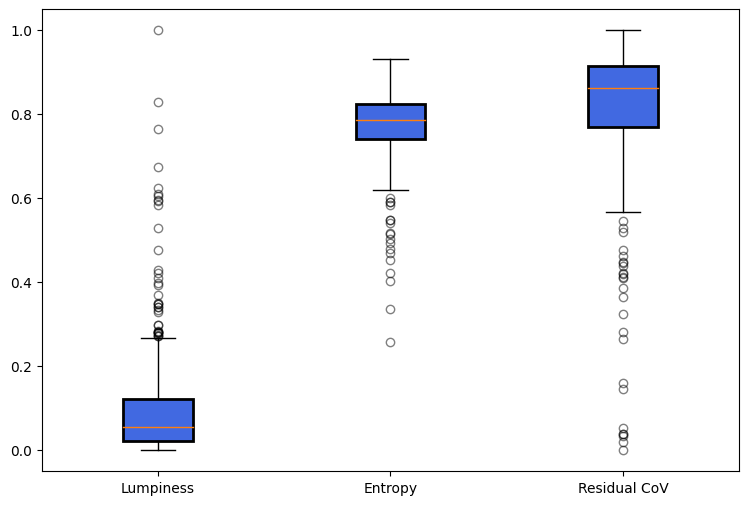

In [11]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['lumpiness'], features['entropy'], features['Residual_CoV']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['Lumpiness', 'Entropy', 'Residual CoV'])

plt.show()

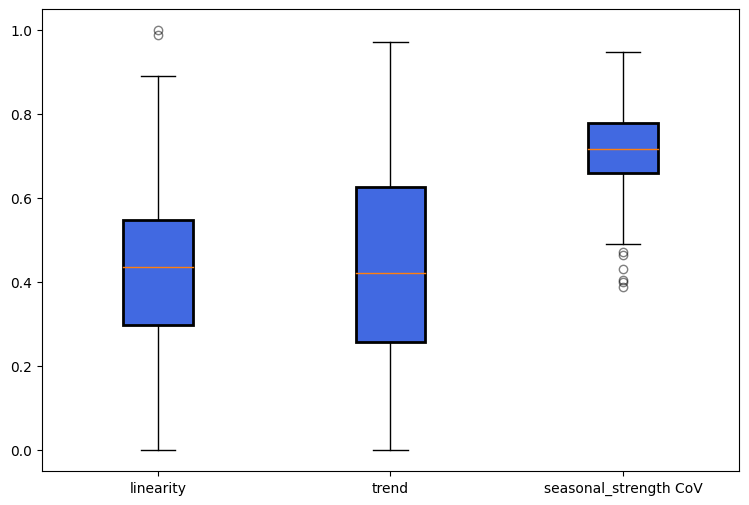

In [12]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['linearity'], features['trend'], features['seasonal_strength']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['linearity', 'trend', 'seasonal_strength CoV'])

plt.show()

#### Statistical Forecaster

In [13]:
# Define some parameters
freq = 'M'
holdout = True
h = 6
cv = 4
models = ['ETS', 'Naive', 'SNaive', 'CrostonOptimized']

In [14]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq, distributed=True, n_partitions=10)

# Fit the forecaster
forecaster.fit(sample_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

2023-04-05 15:28:07,821 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y3tidzcb', purging
2023-04-05 15:28:07,822 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-vldr2n6l', purging
2023-04-05 15:28:07,824 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-z33wudto', purging
2023-04-05 15:28:07,824 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xpebf_7o', purging


make fugue


In [15]:
# Evaluate

# Define the evaluator
evaluator = Evaluator(sample_df, forecast_df, freq = freq, format = 'pivoted')
eval_df = evaluator.evaluate(metrics = metrics)

# keep only relevant columns
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
9288,0_1110,Naive,1,1,0.111242,0.000035,0.029650
9289,0_1110,Naive,2,1,1.130486,0.000358,0.236947
9290,0_1110,Naive,3,1,0.351474,-0.000111,0.106861
9291,0_1110,Naive,4,1,1.487665,0.000471,0.290093
9292,0_1110,Naive,5,1,0.276996,0.000088,0.070706
...,...,...,...,...,...,...,...
46435,9_5923,CrostonOptimized,5,4,0.859279,-0.000272,0.285156
46436,9_5923,CrostonOptimized,6,4,0.286271,-0.000091,0.079822
46437,9_5923,CrostonOptimized,7,4,0.750087,0.000238,0.162261
46438,9_5923,CrostonOptimized,8,4,1.397890,0.000443,0.265228


##### EDA on the Results

In [16]:
# merge eval_df with features on the unique
# groupby on time-series and model
eval_df_ = eval_df.groupby(['unique_id', 'Model']).mean().reset_index()

# add the features
eval_df_ = pd.merge(eval_df_, features, left_on = 'unique_id', right_on = 'unique_id', how = 'left')

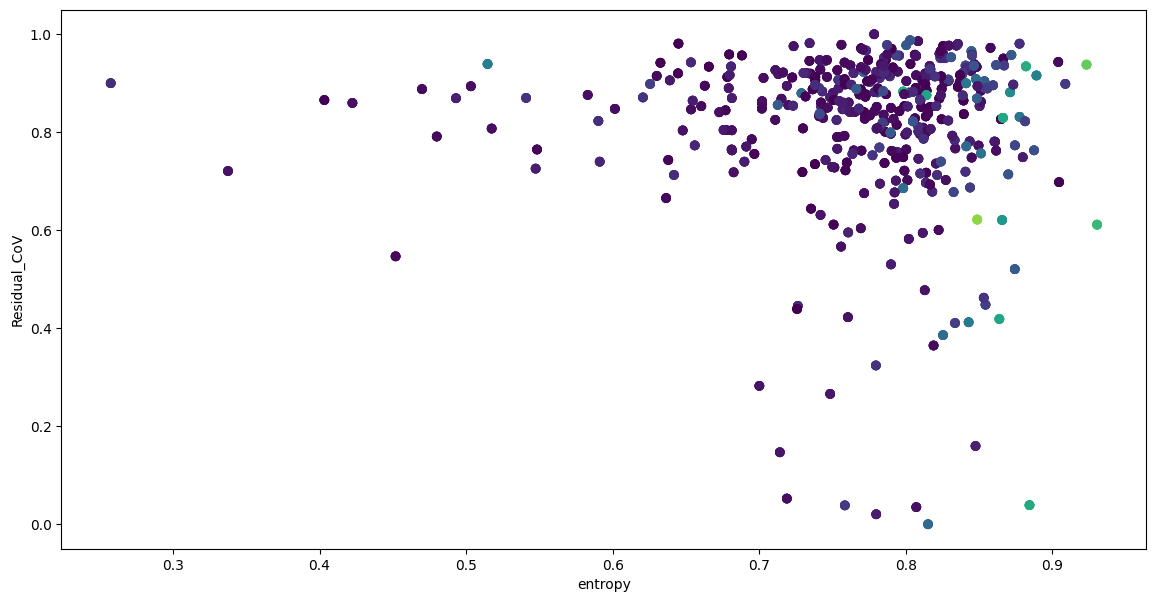

In [17]:
# A scatter plot with entropy on x and Residual_CoV on y 

plt.figure(figsize = (14,7))
plt.scatter(eval_df_['entropy'], eval_df_['Residual_CoV'], c = eval_df_['lumpiness'])

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')
plt.show()



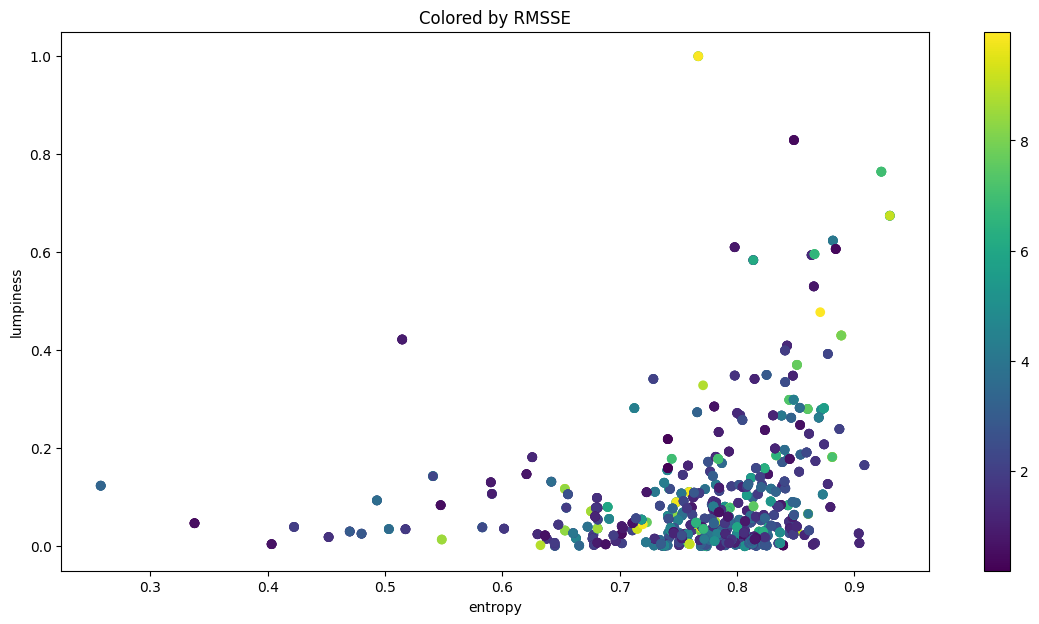

In [18]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['lumpiness'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('lumpiness')
plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

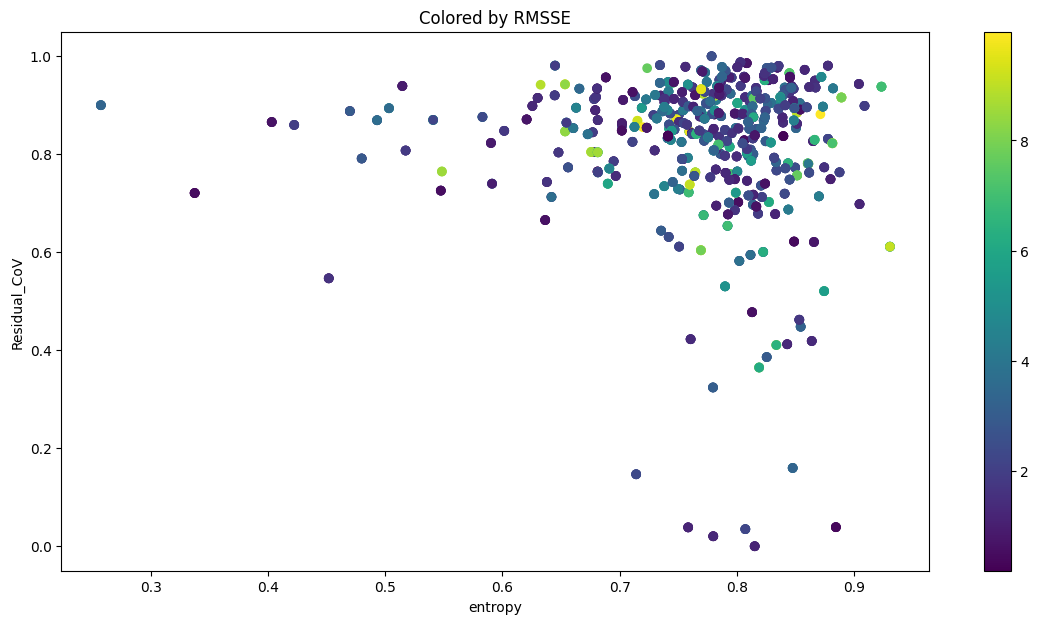

In [19]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['Residual_CoV'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')

plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

#### LGBM Forecaster

In [20]:
# Define features and transformations 

# Best lag is 11 -> I have already tried
features = {'lags': 11}
transformations = {'normalize': 'StandardScaler'}

# Define model specific
loss_f = 'mae' # Default selection
random_state = 42
model = lgb.LGBMRegressor(objective = loss_f, random_state = random_state, use_missing = True)
model_name = 'lgbm'

In [21]:
lgbm_forecaster = GlobalForecaster(model = model ,
                                    features = features, 
                                    transformations = transformations,
                                    model_name =  model_name)
# Fit 
lgbm_forecaster.fit(sample_df)

# Predict
global_fc = lgbm_forecaster.predict(h = h, cv = cv)

In [22]:
# Define the evaluator
evaluator = Evaluator(sample_df, global_fc, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
9288,0_1110,Naive,1,1,0.111242,0.000035,0.029650
9289,0_1110,Naive,2,1,1.130486,0.000358,0.236947
9290,0_1110,Naive,3,1,0.351474,-0.000111,0.106861
9291,0_1110,Naive,4,1,1.487665,0.000471,0.290093
9292,0_1110,Naive,5,1,0.276996,0.000088,0.070706
...,...,...,...,...,...,...,...
9283,10_987,lgbm,2,4,0.249949,-0.000038,0.054909
9284,10_987,lgbm,3,4,0.079793,-0.000012,0.014640
9285,10_987,lgbm,4,4,0.098114,0.000015,0.014341
9286,10_987,lgbm,5,4,0.088840,-0.000014,0.016097


#### Temporal Hierarchies

In [23]:
factors = get_factors(freq = h) # 6 months total -> so factors of 6
factors

array([1, 2, 3, 6])

In [24]:
# Starting with Naive
model = 'Naive'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_naive = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])


In [25]:
# Next with ETS
model = 'ETS'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_ets = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [26]:
# Next with ETS
model = 'CrostonOptimized'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_croston = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [27]:
# Base forecast combinations

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [28]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_mean)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [29]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_median)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Sectional

In [9]:
# Initialize Arguments
current = ['Product', 'ID']
correct = ['ID', 'Product']
splitter = '_'
total = True

In [31]:
# Start with Naive
model = 'Naive'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_naive = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [32]:
# Start with Naive
model = 'ETS'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_ets = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [33]:
# Start with Naive
model = 'CrostonOptimized'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_croston = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [34]:
# Base forecast combinations

# Extend forecasts to include the hierarchical level
base_forecasts_naive = hierarchical_to_transaction(base_forecasts_naive, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_ets = hierarchical_to_transaction(base_forecasts_ets, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_croston = hierarchical_to_transaction(base_forecasts_croston, chief.hierarchical_format, sort_by = False, format = 'transaction')


# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'True':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'True_first': 'True', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'True', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'True', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

base_forecasts_combined_median

,unique_id,cross_sectional_level,fh,cv,y,True,date,Model
0,T,total,1,1,3.208326e+07,26881746.0,2021-07-31,Median_Combination
1,T,total,2,1,3.208326e+07,32981616.0,2021-08-31,Median_Combination
2,T,total,2,2,3.117868e+07,32981616.0,2021-08-31,Median_Combination
3,T,total,3,1,3.208326e+07,25052240.0,2021-09-30,Median_Combination
4,T,total,3,2,3.117868e+07,25052240.0,2021-09-30,Median_Combination
...,...,...,...,...,...,...,...,...
9619,T_9_7434,ID,7,3,1.798587e+04,18529.0,2022-01-31,Median_Combination
9620,T_9_7434,ID,7,4,1.687741e+04,18529.0,2022-01-31,Median_Combination
9621,T_9_7434,ID,8,3,1.798587e+04,14094.0,2022-02-28,Median_Combination
9622,T_9_7434,ID,8,4,1.687741e+04,14094.0,2022-02-28,Median_Combination


In [35]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_median, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [36]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_mean, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Temporal

In [37]:
# Start with Naive
models = 'Naive'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_naive = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Naive'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [38]:
# Start with Naive
models = 'ETS'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_ets = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-ETS'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [39]:
# Start with Naive
models = 'CrostonOptimized'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_croston = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-CrostonOptimized'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [40]:
# Base forecast combinations
# Change some types
base_forecasts_naive['cross_sectional_level'] = base_forecasts_naive['cross_sectional_level'].astype(str)
base_forecasts_ets['cross_sectional_level'] = base_forecasts_ets['cross_sectional_level'].astype(str)
base_forecasts_croston['cross_sectional_level'] = base_forecasts_croston['cross_sectional_level'].astype(str)

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [41]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_median, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Median_Combination'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [42]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_mean, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Mean_Combination'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Analyze Results

In [44]:
# Drop any duplicates
eval_df = eval_df.drop_duplicates(subset = ['unique_id', 'Model', 'fh', 'cv'])

In [45]:
# Best model
eval_df.groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
19,lgbm,0.986886,-0.000002,0.207681
17,TR-struc-Median_Combination,6.809784,-0.000908,0.274825
18,TR-struc-Naive,4.279682,-0.000248,0.310146
5,CTR-struc-Naive,4.279682,-0.000248,0.310146
11,HR-struc-Naive,4.805237,0.000200,0.316361
12,Naive,4.805237,0.000200,0.316361
14,TR-struc-AutoETS,4.366473,-0.000381,0.323055
0,AutoETS,4.562217,-0.000469,0.339071
13,SeasonalNaive,5.615018,-0.000919,0.396087
4,CTR-struc-Median_Combination,4.446663,-0.000355,0.424746


In [48]:
# Best model no outliers
eval_df[eval_df['rmsse'] < 10].groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
19,lgbm,0.788167,0.000006,0.165699
17,TR-struc-Median_Combination,2.742619,-0.000262,0.236694
18,TR-struc-Naive,2.440806,-0.000163,0.267335
5,CTR-struc-Naive,2.440805,-0.000163,0.267335
11,HR-struc-Naive,2.498898,0.000096,0.269516
12,Naive,2.498898,0.000096,0.269516
14,TR-struc-AutoETS,2.469844,-0.000207,0.277299
0,AutoETS,2.536633,-0.000224,0.294538
13,SeasonalNaive,2.368130,-0.000268,0.300481
4,CTR-struc-Median_Combination,2.476940,-0.000202,0.355152


In [56]:
import seaborn as sns

In [86]:
def classify_techniques(model):
    if 'CTR' in model:
        out = 'Cross_Temporal'
    elif 'TR' in model:
        out = 'Temporal'
    elif 'HR' in model:
        out = 'Cross_Sectional'
    else:
        out = 'Base'
    return out

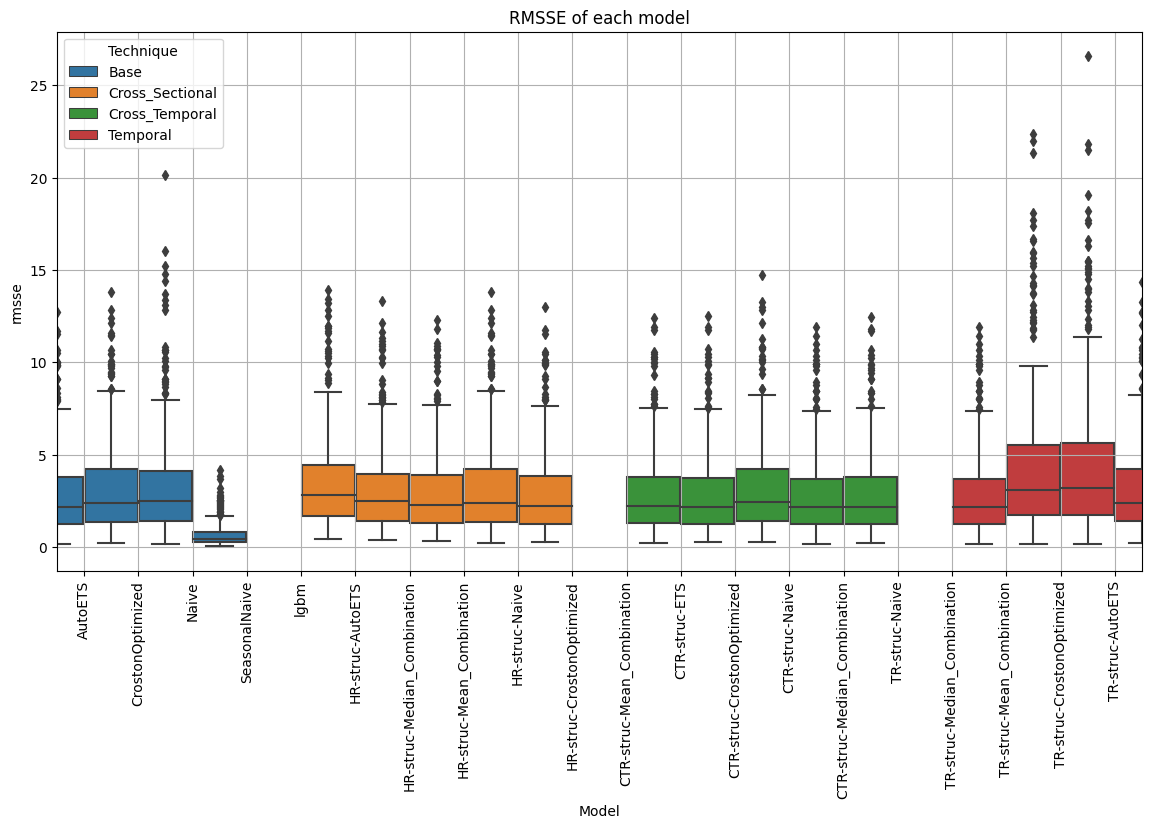

In [97]:
# remove out
remove_out = True
total_outliers = 25

eval_df_group = eval_df.groupby(['unique_id','Model']).mean().reset_index().drop('cv', axis = 1)
# classify techniques
eval_df_group['Technique'] = eval_df_group['Model'].apply(classify_techniques)

# find the outlier series
# mean rmsse over 50
outliers = eval_df_group.groupby(['unique_id']).mean().reset_index().sort_values('rmsse', ascending = False).head(total_outliers)['unique_id'].values

if remove_out:
    eval_df_group = eval_df_group[~eval_df_group['unique_id'].isin(outliers)]

# Remove outlier mapes
#eval_df_group = eval_df_group[eval_df_group['rmsse'] < 10]

# A boxplot for the rmsse of each model on the eval_df_group df
# Models should be grouped based on the Technique

# Sort the dataframe based on the technique
eval_df_group = eval_df_group.sort_values('Technique')

# Figure
fig, ax = plt.subplots(figsize = (14, 7))

# Boxplots, color should be based on the technique
# Distance and width should be adjusted
sns.boxplot(x = 'Model', y = 'rmsse', data = eval_df_group, ax = ax, hue = 'Technique', width = 4)

ax.grid()

ax.set_title('RMSSE of each model')

ax.set_xlabel('Model')

ax.set_ylabel('rmsse')

plt.xticks(rotation = 90)

plt.show()

